# Questão 1

Implemente e treine duas redes neurais artificiais para o problema de classificação de dígitos  
manuscritos, utilizando a base de dados MNIST, disponível em:  
https://www.kaggle.com/datasets/hojjatk/mnist-dataset.  

A primeira rede deve ser um Perceptron de Múltiplas Camadas (MLP) tradicional,  
enquanto a segunda deve ser uma Rede Neural Convolucional (CNN).  

Compare o desempenho das duas redes por meio da análise da curva  
do erro médio durante o treinamento e da matriz de confusão obtida no conjunto de teste.

# Questão 2

Implemente e treine uma Rede Neural Convolucional (CNN) para resolver o problema de
classificação de objetos em imagens, utilizando a base de dados CIFAR-10, disponível em:
https://www.cs.toronto.edu/~kriz/cifar.html.
Apresente a curva do erro médio ao longo do treinamento, bem como a matriz de confusão do
modelo avaliado sobre o conjunto de teste.

Loaded in this way, each of the batch files contains a dictionary with the following elements:

    data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
    labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.


The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

    label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.


In [59]:
import tarfile
import pickle
import numpy as np
import os
import subprocess
import zipfile
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential

In [60]:
def unpickle(file):
    """
    Unpickles a file from a tar.gz archive.

    Args:
        file (str): The path to the tar.gz archive.

    Returns:
        dict: The unpickled dictionary.
    """
    data = {}
    with tarfile.open(file, 'r:gz') as tar:
        for member in tar.getmembers():
            if member.name.startswith('cifar-10-batches-py/data_batch_'):
                f = tar.extractfile(member)
                if f is not None:
                    batch_data = pickle.load(f, encoding='bytes')
                    data[member.name.split('/')[-1]] = batch_data  # Store with batch name as key

    return data

In [61]:
# download dataset 

if not os.path.exists('data'):
    os.makedirs('data')
    print("Pasta 'data/' criada.")

url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
zip_file = "data/cifar-10-python.tar.gz"
if not os.path.exists(zip_file):
    try:
        # Baixar o arquivo usando wget
        print("Baixando o dataset...")
        wget_command = f"wget {url} -O {zip_file}"
        subprocess.run(wget_command, shell=True, check=True)
        print("Download concluído!")
            
    except subprocess.CalledProcessError as e:
        print(f"Erro ao baixar o arquivo: {e}")
    except Exception as e:
        print(f"Erro durante o processamento: {e}")

In [62]:
data = unpickle('data/cifar-10-python.tar.gz')

In [63]:
data['data_batch_4'][b'data'][:5]

array([[178, 178, 178, ...,  80,  80,  77],
       [ 29,  22,  25, ...,  29,  31,  30],
       [ 36,  33,  21, ..., 173, 170, 170],
       [ 30,  45,  44, ..., 106,  99, 147],
       [ 35,  80,  89, ..., 107, 110,  92]], dtype=uint8)

In [64]:
def organize_cifar_batches(data):
    """
    Organizes CIFAR-10 data into separate arrays for images and labels, grouped by batch.

    Args:
        data (dict): The unpickled CIFAR-10 data.

    Returns:
        tuple: A tuple containing:
            - images (np.array): A NumPy array containing all images.
            - labels (np.array): A NumPy array containing all labels.
            - label_names (list): A list of class names for the CIFAR-10 dataset.
    """
    images_by_batch = []
    labels_by_batch = []

    num_batches = 5  # CIFAR-10 has 5 data batches

    for batch_num in range(1, num_batches + 1):
        batch_key = f'data_batch_{batch_num}'
        if batch_key in data:
            batch_data = data[batch_key]  # Extract data from current batch using its key

            images = batch_data[b'data']  # Extract images (3072 values per image)
            labels = batch_data[b'labels']  # Extract labels (10 labels)

            images_by_batch.append(np.array(images))
            labels_by_batch.append(np.array(labels))

    # Concatena as imagens e labels de todos os lotes
    images = np.concatenate(images_by_batch, axis=0)  # Combina as imagens de todos os lotes
    labels = np.concatenate(labels_by_batch, axis=0)  # Combina os rótulos de todos os lotes

    # Definindo os nomes das classes
    label_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
    ]

    return images, labels, label_names

In [65]:
images, labels, label_names = organize_cifar_batches(data)

In [66]:
# Passo 1: Pré-processamento dos Dados

# Reshape do vetor de dados
data = images.reshape(50000, 3, 32, 32)  # 3 canais, 32x32 pixels por imagem
data = data.transpose(0, 2, 3, 1)  # Mudar para o formato (num_imagens, altura, largura, canais)
data = data.astype('float32')

data /= 255.0  # Normalização dos valores para o intervalo [0, 1]

In [67]:
# Divisão entre treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Divisão entre treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [68]:
# Passo 2: Construção da Rede Convolucional

model = Sequential()
# Primeira camada convolucional com 32 filtros e tamanho de kernel 3x3
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
# Segunda camada convolucional com 64 filtros
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# Terceira camada convolucional com 128 filtros
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# Flatten para transformar as saídas 2D em 1D
model.add(Flatten())
# Camada totalmente conectada com 128 neurônios
model.add(Dense(128, activation='relu'))
# Camada de saída com 10 neurônios (um para cada classe de 0 a 9) e softmax para classificação multi-classe
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/home/erlo/.localvenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [70]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping], batch_size=64, verbose=1)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.2852 - loss: 1.9212 - val_accuracy: 0.4789 - val_loss: 1.4286
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5075 - loss: 1.3648 - val_accuracy: 0.5304 - val_loss: 1.3048
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5763 - loss: 1.1760 - val_accuracy: 0.6109 - val_loss: 1.1009
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6367 - loss: 1.0323 - val_accuracy: 0.6316 - val_loss: 1.0518
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6723 - loss: 0.9324 - val_accuracy: 0.6685 - val_loss: 0.9884
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7036 - loss: 0.8481 - val_accuracy: 0.6616 - val_loss: 0.9861
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7319 - loss: 0.7802 - val_accuracy: 0.6668 - val_loss: 0.9774
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.7462 - loss: 0.

In [71]:
test_loss, test_acc = model.evaluate(X_test, np.array(y_test))
print(f"Test accuracy: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6902 - loss: 0.8995
Test accuracy: 0.691100001335144


In [72]:
def plot_images(images, labels, predicted_labels=None):
    """
    Plota as imagens com seus rótulos reais e previstos.

    Args:
        images (np.array): Array de imagens.
        labels (np.array): Rótulos reais das imagens.
        predicted_labels (np.array, optional): Rótulos previstos das imagens.
    """
    plt.figure(figsize=(10, 10))
    num_images = len(images)
    total_rows = (num_images + 2) // 3
    for i in range(num_images):
        ax = plt.subplot(total_rows, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Real: {label_names[labels[i]]}\nPredito: {label_names[predicted_labels[i]] if predicted_labels is not None else 'N/A'}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [73]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

missclassified_indices = np.where(predicted_classes != y_test)[0]
print(f"Total de imagens mal classificadas: {len(missclassified_indices)} de {len(y_test)}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Total de imagens mal classificadas: 3089 de 10000


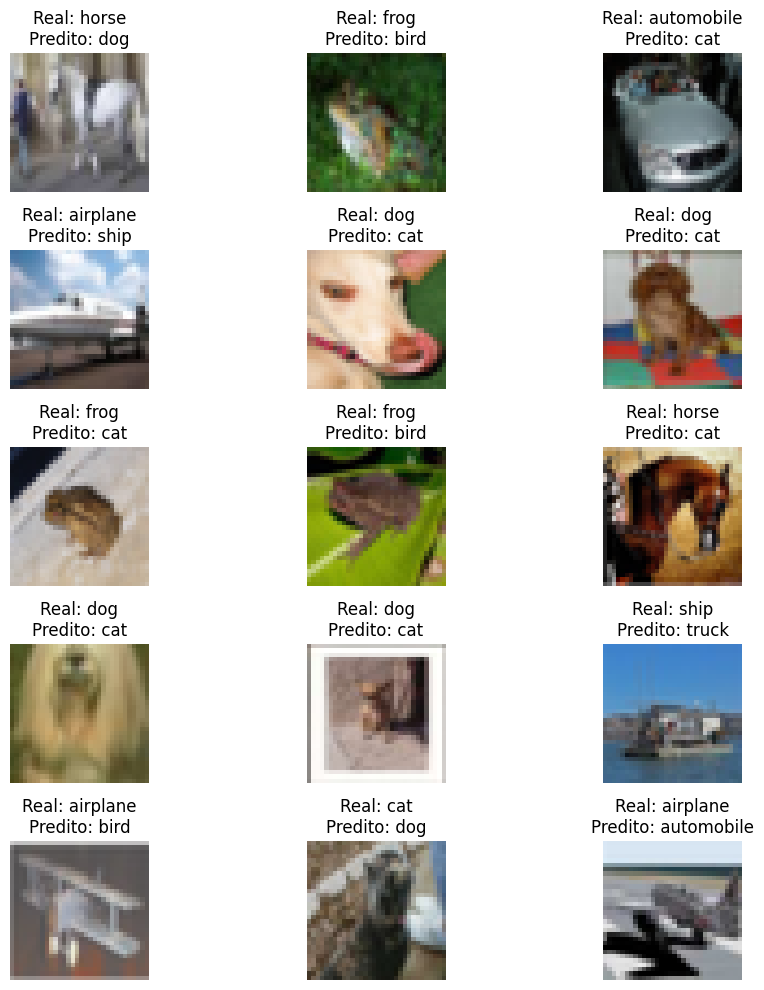

In [76]:
# Exemplos de previsão do conjunto de teste
# Plotando as 15 primeiras imagens mal classificadas
X_missclassified = X_test[missclassified_indices[:15]]
y_missclassified = y_test[missclassified_indices[:15]]
predicted_missclassified = predicted_classes[missclassified_indices[:15]]
plot_images(X_missclassified, y_missclassified, predicted_labels=predicted_missclassified)

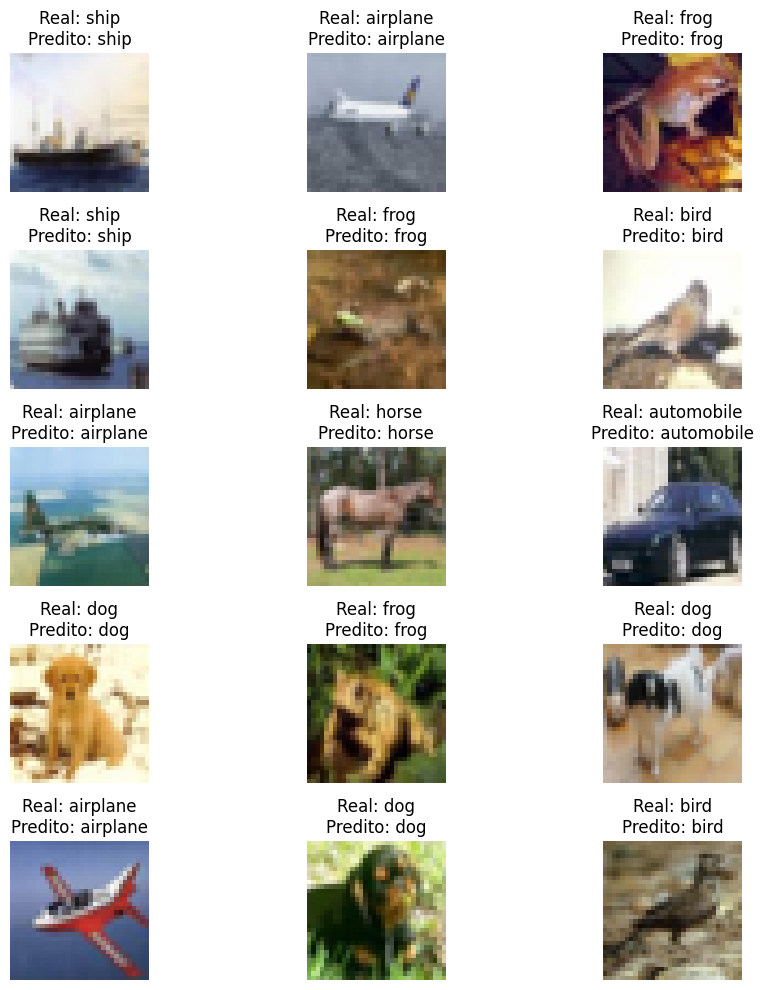

In [77]:
# 15 primeiras imagens corretamente classificadas 
X_accurate = X_test[predicted_classes == y_test]
y_accurate = y_test[predicted_classes == y_test]
X_accurate = X_accurate[:15]
y_accurate = y_accurate[:15]
predicted_accurate = predicted_classes[predicted_classes == y_test][:15]

plot_images(X_accurate, y_accurate, predicted_labels=predicted_accurate)

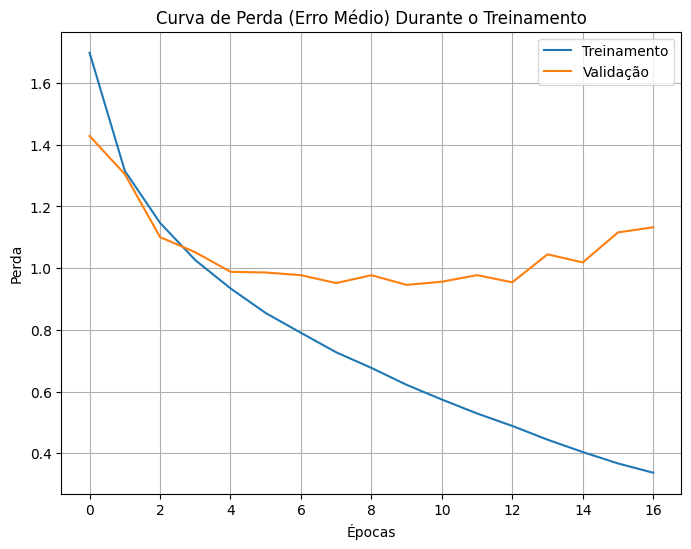

In [78]:
# Curva de erro 
plt.figure(figsize=(8, 6))

plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')

# Configurando o gráfico
plt.title('Curva de Perda (Erro Médio) Durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(loc='upper right')
plt.grid(True)

# Exibindo o gráfico
plt.show()

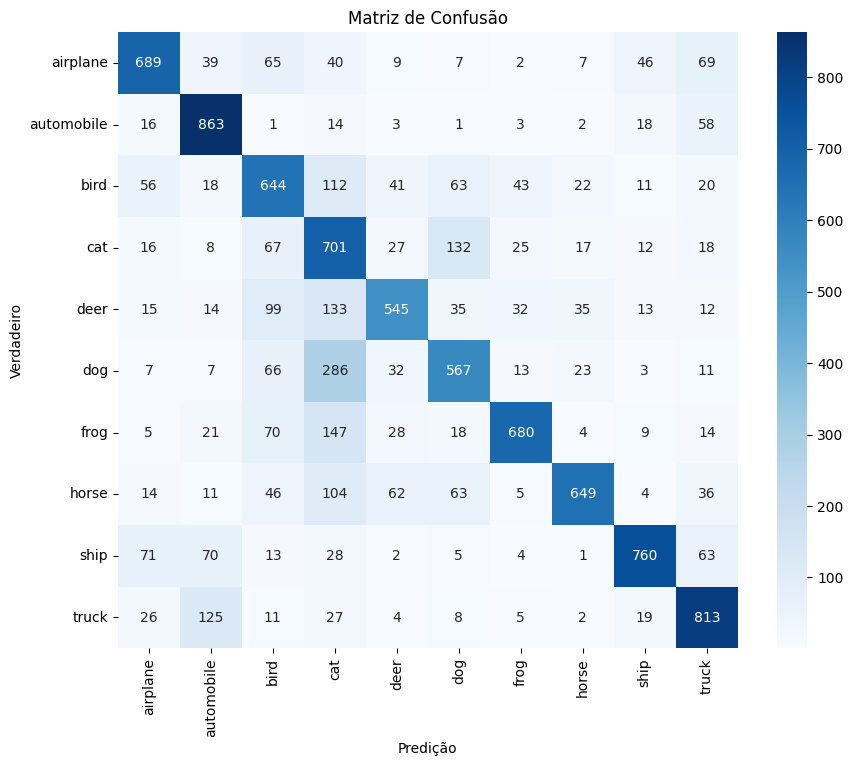

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Gerando a matriz de confusão
cm = confusion_matrix(y_test, predicted_classes)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.show()

# Questão 3

a) Implemente e treine um autoencoder utilizando o dataset Fashion-MNIST, disponível em:
https://www.kaggle.com/datasets/zalando-research/fashionmnist. O objetivo deste exercício é
compreender como esse tipo de rede neural é capaz de aprender representações comprimidas
de dados e realizar reconstruções a partir dessas representações. O autoencoder pode ser
construído utilizando apenas camadas densas (fully connected) ou, alternativamente, camadas
convolucionais e deconvolucionais.
Após o treinamento, selecione 10 imagens do conjunto de teste e utilize o modelo treinado para
gerar as reconstruções correspondentes. Apresente os resultados visualmente, exibindo lado a
lado as imagens originais e suas respectivas reconstruções, de modo que seja possível avaliar
qualitativamente o desempenho do autoencoder. Apresente também a curva do erro médio ao
longo do treinamento.

(b) Complete o exercício da questão 3(a) adicionando ruído aleatório às imagens de entrada,
com o objetivo de treinar um denoising autoencoder. Após o treinamento, utilize as 10 imagens
selecionadas na questão anterior (com o ruído aplicado) e apresente os resultados
visualmente, exibindo lado a lado as imagens originais e suas respectivas reconstruções. Avalie
qualitativamente o desempenho do modelo em remover o ruído e preservar as características
das imagens originais.

# Questão 4

Implemente uma Rede Neural Recorrente (RNN), como por exemplo uma LSTM ou GRU,
para o problema de Análise de Sentimentos, utilizando a base de dados de resenhas de filmes
do IMDb (Internet Movie Database).
Essa base contém 50 mil resenhas em inglês, sendo 25 mil para treinamento e 25 mil para
teste, cada uma acompanhada de uma avaliação binária que indica se a resenha é negativa (0)
ou positiva (1). A base está disponível em:
https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews.
Descreva o processo de pré-processamento dos dados, a arquitetura da RNN implementada,
os parâmetros utilizados no treinamento e os principais resultados obtidos (como acurácia,
curva de erro e exemplos de inferências (classificações no conjunto de teste)).